In [1]:
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime
from IPython.display import display, HTML

In [2]:
def selecionar_aprovados(dados, coluna_aprovado_discursiva, coluna_situacao):

    df = dados.copy(deep=True)

    # Seleciona os 81 primeiros candidatos aprovados
    df.loc[df.loc[df[coluna_aprovado_discursiva] == True].head(81).index, coluna_situacao] = "Aprovado nas vagas de ampla concorrência"

    # Seleciona os candidatos aprovados PCD que ainda não foram incluídos
    df.loc[df.loc[(df[coluna_situacao].isna()) & 
                  (df["SITUACAO OBJETIVA"] == "Aprovado PcD") &
                  (df[coluna_aprovado_discursiva] == True)].head(9).index, coluna_situacao] = "Aprovado nas vagas de cota PCD"

    # Caso não haja 9 candidatos aprovados PCD, completa com aprovados na Ampla
    if len(df[df[coluna_situacao] == "Aprovado nas vagas de cota PCD"]) < 9:
        df.loc[df.loc[(df[coluna_situacao].isna()) &
                      (df[coluna_aprovado_discursiva] == True)].head(9 - len(df[df[coluna_situacao] == "Aprovado nas vagas de cota PCD"])).index, coluna_situacao] = "Aprovado nas vagas de ampla concorrência"

    df.loc[(df[coluna_situacao].isna()) & 
           (df[coluna_aprovado_discursiva] == True), coluna_situacao] = "Cadastro de Reservas"

    df[coluna_situacao] = df[coluna_situacao].fillna('Reprovado na discursiva')
      
    # Retorna os 81 primeiros aprovados + os 9 primeiros aprovados PCD
    return df

In [3]:
resultado_objetiva = pd.read_csv('./data/resultado-objetiva.csv', sep=";", index_col=['INSC_NUMB', 'NOME'])
resultado_objetiva['NASC'] = pd.to_datetime(resultado_objetiva['NASC'], format='%d/%m/%Y')
resultado_objetiva['IDADE'] = (datetime.today() - resultado_objetiva['NASC']).astype('timedelta64[Y]')
resultado_objetiva['IDOSO'] = resultado_objetiva['IDADE'] >= 60

resultado_discursiva_preliminar = pd.read_csv('./data/resultado-discursiva-preliminar.csv', sep=";", index_col=['INSC_NUMB', 'NOME'])
resultado_discursiva_definitivo = pd.read_csv('./data/resultado-discursiva-definitivo.csv', sep=";", index_col=['INSC_NUMB', 'NOME'])

In [4]:
resultado_definitivo = resultado_objetiva.merge(resultado_discursiva_preliminar, on=['INSC_NUMB', 'NOME'], how='left').merge(resultado_discursiva_definitivo, on=['INSC_NUMB', 'NOME'], how='left', suffixes=('_p', '_d'))

In [5]:
resultado_definitivo['TOTAL_p'] = resultado_definitivo['TOTAL OBJETIVA'] + resultado_definitivo['TOTAL DISCURSIVA_p'].fillna(value=0)
resultado_definitivo['APROVADO DISCURSIVA_p'] = resultado_definitivo['TOTAL DISCURSIVA_p'] >= 40

resultado_definitivo['TOTAL_d'] = resultado_definitivo['TOTAL OBJETIVA'] + resultado_definitivo['TOTAL DISCURSIVA_d'].fillna(value=0)
resultado_definitivo['APROVADO DISCURSIVA_d'] = resultado_definitivo['TOTAL DISCURSIVA_d'] >= 40


In [6]:
resultado_definitivo_ordenado = resultado_definitivo.sort_values(by=['APROVADO DISCURSIVA_p', 'TOTAL_p', 'IDOSO', 'TOTAL DISCURSIVA_d', 'P2', 'CD', 'DEV', 'BD', 'NASC'], 
                                               ascending=[False, False, False, False, False, False, False, False, True])
resultado_definitivo_ordenado = resultado_definitivo_ordenado.reset_index(drop=False)
resultado_definitivo_ordenado['POS_p'] = np.where(~np.isnan(resultado_definitivo_ordenado['TOTAL DISCURSIVA_p']), resultado_definitivo_ordenado.index + 1, np.nan)
resultado_definitivo_ordenado = selecionar_aprovados(resultado_definitivo_ordenado, "APROVADO DISCURSIVA_p", "SITUAÇÃO PRELIMINAR")

In [7]:
resultado_definitivo_ordenado = resultado_definitivo_ordenado.sort_values(by=['APROVADO DISCURSIVA_d', 'TOTAL_d', 'IDOSO', 'TOTAL DISCURSIVA_d', 'P2', 'CD', 'DEV', 'BD', 'NASC'], 
                                               ascending=[False, False, False, False, False, False, False, False, True])
resultado_definitivo_ordenado = resultado_definitivo_ordenado.reset_index(drop=False)
resultado_definitivo_ordenado['POS_d'] = np.where(~np.isnan(resultado_definitivo_ordenado['TOTAL DISCURSIVA_d']), resultado_definitivo_ordenado.index + 1, np.nan)
resultado_definitivo_ordenado = selecionar_aprovados(resultado_definitivo_ordenado, "APROVADO DISCURSIVA_d", "SITUAÇÃO DEFINITIVA")

In [8]:
materias = ['PT','RLM','DALE','DCDH','DCDE','DP','DT','CONT','EMF','ING','CD','DEV','BD','IT','SEG','LTE','P1','P2','TOTAL OBJETIVA']

resultados = []
for materia in materias:
    corr = resultado_definitivo_ordenado['APROVADO DISCURSIVA_d'].corr(resultado_definitivo_ordenado[materia])
    resultados.append((materia, corr))

# Ordenar a lista de resultados em ordem decrescente de correlação
resultados_ordenados = sorted(resultados, key=lambda x: x[1], reverse=True)

# Imprimir os resultados ordenados
print('Correlação entre aprovados e nota das disciplinas')
for materia, corr in resultados_ordenados:
    print(f'{materia}: {corr}')

Correlação entre aprovados e nota das disciplinas
TOTAL OBJETIVA: 0.46262018299384833
P2: 0.43273550273213174
P1: 0.37224802119212347
SEG: 0.3085012922400694
RLM: 0.3044316530323362
BD: 0.23705831921446022
DT: 0.22662299878936468
ING: 0.22060793051768887
DALE: 0.21508750501153162
DCDH: 0.20013834103927977
DP: 0.19397370347170068
LTE: 0.17331277566832687
CONT: 0.16743887397825233
DEV: 0.16566661830000934
DCDE: 0.16566069444421933
EMF: 0.15867050812456085
IT: 0.14346189795018677
PT: 0.12660158294591356
CD: 0.042738909659681475


In [9]:
materias = ['PT','RLM','DALE','DCDH','DCDE','DP','DT','CONT','EMF','ING','CD','DEV','BD','IT','SEG','LTE','P1','P2','TOTAL OBJETIVA']

resultados = []
for materia in materias:
    corr = resultado_definitivo_ordenado['TOTAL DISCURSIVA_d'].corr(resultado_definitivo_ordenado[materia])
    resultados.append((materia, corr))

# Ordenar a lista de resultados em ordem decrescente de correlação
resultados_ordenados = sorted(resultados, key=lambda x: x[1], reverse=True)

# Imprimir os resultados ordenados
print('Correlação entre nota na discursiva e nota das disciplinas')
for materia, corr in resultados_ordenados:
    print(f'{materia}: {corr}')

Correlação entre nota na discursiva e nota das disciplinas
TOTAL OBJETIVA: 0.3244768925418288
P2: 0.30415283700760143
P1: 0.2388186151009318
ING: 0.22558315670718407
DT: 0.21332195163021964
CD: 0.20698715988730013
RLM: 0.19665580883143827
DCDH: 0.1688366952325871
CONT: 0.159697258538579
DCDE: 0.1481036832614057
DALE: 0.14290590428776692
DP: 0.11227822977848126
DEV: 0.11063480700991057
SEG: 0.10928609077229934
LTE: 0.09362555356875193
BD: 0.08833559040271712
IT: 0.08595840525311844
PT: 0.006500797430895965
EMF: -0.0488297000490551


In [10]:
import matplotlib.pyplot as plt
import plotly.express as px

v1 = 'TOTAL DISCURSIVA_d'
v2 = 'TOTAL OBJETIVA'
# Plotar o gráfico de dispersão
# plt.scatter(resultado_definitivo_ordenado[v1], resultado_definitivo_ordenado[v2])

fig = px.scatter(resultado_definitivo_ordenado, x=v1, y=v2, color='SITUAÇÃO DEFINITIVA', opacity=0.5)

fig.update_layout(width=1000, height=700)

fig.show()

In [11]:
import matplotlib.pyplot as plt
import plotly.express as px

v1 = 'TOTAL DISCURSIVA_d'
v2 = 'P2'
# Plotar o gráfico de dispersão
# plt.scatter(resultado_definitivo_ordenado[v1], resultado_definitivo_ordenado[v2])

fig = px.scatter(resultado_definitivo_ordenado, x=v1, y=v2, color='SITUAÇÃO DEFINITIVA', opacity=0.5)

fig.update_layout(width=1000, height=700)

fig.show()

In [12]:
import matplotlib.pyplot as plt
import plotly.express as px

v1 = 'TOTAL DISCURSIVA_d'
v2 = 'P1'
# Plotar o gráfico de dispersão
# plt.scatter(resultado_definitivo_ordenado[v1], resultado_definitivo_ordenado[v2])

fig = px.scatter(resultado_definitivo_ordenado, x=v1, y=v2, color='SITUAÇÃO DEFINITIVA', opacity=0.5)

fig.update_layout(width=1000, height=700)

fig.show()

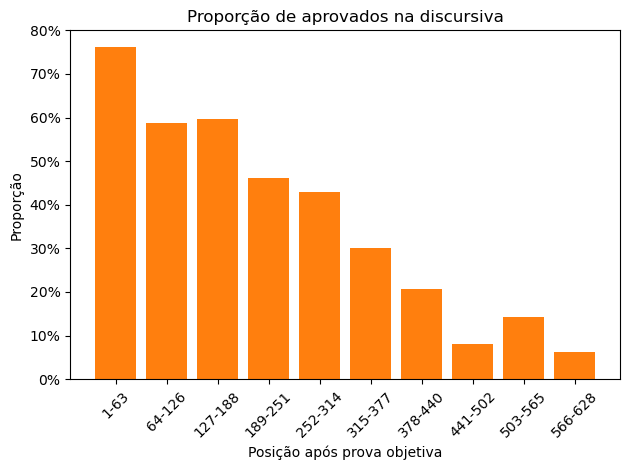

In [13]:
import matplotlib.ticker as mticker

# Definir os intervalos
intervals = [
    (1, 63),
    (64, 126),
    (127, 188),
    (189, 251),
    (252, 314),
    (315, 377),
    (378, 440),
    (441, 502),
    (503, 565),
    (566, 628)
]

# Inicializar uma lista para armazenar as proporções
proporcoes = []

# Iterar sobre os intervalos
for interval in intervals:
    # Filtrar o DataFrame dentro do intervalo
    filtro = (resultado_definitivo_ordenado['POS OBJETIVA'] >= interval[0]) & (resultado_definitivo_ordenado['POS OBJETIVA'] <= interval[1])
    df_intervalo = resultado_definitivo_ordenado[filtro]

    # Calcular a proporção onde 'TOTAL DISCURSIVA' é diferente de NaN
    proporcao = df_intervalo['TOTAL DISCURSIVA_d'].notna().mean()
    proporcoes.append(proporcao)

# Criar um DataFrame com as proporções
df_proporcoes = pd.DataFrame({'Intervalo': [f'{interval[0]}-{interval[1]}' for interval in intervals], 'Proporção': proporcoes})

fig, ax = plt.subplots()
ax.bar(df_proporcoes['Intervalo'], df_proporcoes['Proporção'])

# Definir a formatação em percentual no eixo Y
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# Plotar o gráfico de barras
plt.bar(df_proporcoes['Intervalo'], df_proporcoes['Proporção'])
plt.xlabel('Posição após prova objetiva')
plt.ylabel('Proporção')
plt.title('Proporção de aprovados na discursiva')
plt.xticks(rotation=45)
plt.tight_layout()

# Exibir o gráfico
plt.show()

In [14]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

x = np.arange(0, 20, 0.5)
width = 0.2

fig = make_subplots(rows=2, cols=2, subplot_titles=('Questão 1', 'Questão 2', 'Questão 3', 'Questão 4'))


hist1, edges1 = np.histogram(resultado_definitivo_ordenado['Q1_d'], bins=np.arange(0, 21, 0.5))
fig.add_trace(go.Bar(x=edges1[:-1], y=hist1, name='Questão 1'), row=1, col=1)

# Gráfico 2
hist2, edges2 = np.histogram(resultado_definitivo_ordenado['Q2_d'], bins=np.arange(0, 21, 0.5))
fig.add_trace(go.Bar(x=edges2[:-1], y=hist2, name='Questão 2'), row=1, col=2)

# Gráfico 3
hist3, edges3 = np.histogram(resultado_definitivo_ordenado['Q3_d'], bins=np.arange(0, 21, 0.5))
fig.add_trace(go.Bar(x=edges3[:-1], y=hist3, name='Questão 3'), row=2, col=1)

# Gráfico 4
hist4, edges4 = np.histogram(resultado_definitivo_ordenado['Q4_d'], bins=np.arange(0, 21, 0.5))
fig.add_trace(go.Bar(x=edges4[:-1], y=hist4, name='Questão 4'), row=2, col=2)

# Atualizar layout
fig.update_layout(height=600, width=800, showlegend=False)

# Exibir a imagem
fig.show()

In [15]:
hist, edges = np.histogram(resultado_definitivo_ordenado['TOTAL DISCURSIVA_d'], bins=np.arange(40, 81, 0.5))

# Criar figura
fig = go.Figure(data=[go.Bar(x=edges[:-1], y=hist)])

# Configurar layout
fig.update_layout(
    title='Histograma - TOTAL DISCURSIVA',
    xaxis_title='Valores',
    yaxis_title='Frequência',
    bargap=0.01
)

# Exibir o histograma
fig.show()

In [16]:
# Selecionar as colunas desejadas
colunas = ["Q1_d", "Q2_d", "Q3_d", "Q4_d", "TOTAL DISCURSIVA_d"]

# Gerar estatísticas básicas
estatisticas = resultado_definitivo_ordenado[colunas].describe()

# Exibir as estatísticas
print(estatisticas)


             Q1_d        Q2_d        Q3_d        Q4_d  TOTAL DISCURSIVA_d
count  228.000000  228.000000  228.000000  228.000000          228.000000
mean    16.697368   15.096491   11.868421    8.326754           51.989035
std      3.712474    4.899823    4.185170    3.886556            8.407890
min      5.500000    0.000000    0.000000    0.000000           40.000000
25%     14.500000   12.000000    8.000000    5.500000           44.875000
50%     18.000000   16.000000   12.000000    8.000000           51.500000
75%     20.000000   20.000000   16.000000   11.500000           57.500000
max     20.000000   20.000000   20.000000   18.000000           76.000000


In [17]:
# Filtrar os valores não NaN da coluna "TOTAL DISCURSIVA"
df_filtrado = resultado_definitivo_ordenado.dropna(subset=["TOTAL DISCURSIVA_d"])

# Selecionar as colunas desejadas
colunas = ["Q1_d", "Q2_d", "Q3_d", "Q4_d"]

# Contar quantas notas 20 cada pessoa teve
df_filtrado["Notas 20"] = df_filtrado[colunas].eq(20).sum(axis=1)

# Criar histograma
hist, edges = np.histogram(df_filtrado["Notas 20"], bins=np.arange(0, len(colunas)+2, 1))

# Criar figura
fig = go.Figure(data=[go.Bar(x=edges[:-1], y=hist)])

# Configurar layout
fig.update_layout(
    title="Histograma - Quantidade de notas 20",
    xaxis_title="Número de notas 20",
    yaxis_title="Frequência"
)

# Exibir o histograma
fig.show()

C:\Users\rafae\AppData\Local\Temp\ipykernel_23016\2510809724.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
candidatos_aprovados = resultado_definitivo_ordenado[resultado_definitivo_ordenado['SITUAÇÃO DEFINITIVA'].str.contains('Aprovado')]

# Criar histograma
fig = go.Figure(data=[go.Histogram(x=candidatos_aprovados['IDADE'])])

# Configurar layout
fig.update_layout(
    title='Histograma - Idade dos candidatos aprovados',
    xaxis_title='Idade',
    yaxis_title='Frequência'
)

# Exibir o histograma
fig.show()

In [20]:
candidatos_aprovados = resultado_definitivo_ordenado[resultado_definitivo_ordenado['APROVADO DISCURSIVA_d'] == True]

# Criar histograma
fig = go.Figure(data=[go.Histogram(x=candidatos_aprovados['IDADE'])])

# Configurar layout
fig.update_layout(
    title='Histograma - Idade dos candidatos aprovados',
    xaxis_title='Idade',
    yaxis_title='Frequência'
)

# Exibir o histograma
fig.show()